Example based on https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
Data: https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)
activity_regularizer: https://machinelearningmastery.com/how-to-reduce-generalization-error-in-deep-neural-networks-with-activity-regularization-in-keras/
http://proceedings.mlr.press/v15/glorot11a.html
https://keras.io/layers/writing-your-own-keras-layers/

In [1]:
import numpy
import pandas

from tensorflow.keras.layers import Dense

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss

import wvpy.util

from YConditionalRegularizedModel import YConditionalRegularizedModel

In [2]:
# load dataset
dataframe = pandas.read_csv("sonar.csv", header=None)

In [3]:
# deal with outcome column, which is the last column
last_col = dataframe.shape[1] - 1
Y = numpy.asarray(dataframe[last_col])
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
Y = None

In [4]:
X = dataframe.values[:, 0:last_col]  # clean copy, no outcome columns
dataframe = None

In [5]:
def example_model_steps():
    return [
        60, # input vector width
        Dense(60, activation='relu'),
        Dense(1, activation='sigmoid'),
    ]

batch_size = 100

In [6]:
def mk_model(alpha):
    estimators = list()
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('mlp', 
                       YConditionalRegularizedModel(
                           example_model_steps, alpha=alpha, 
                           epochs=100, batch_size=batch_size, verbose=0)))
    pipeline = Pipeline(estimators)
    return pipeline

In [7]:
pipeline = mk_model(0.01)

In [8]:
preds = pipeline.fit_transform(X, encoded_Y)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


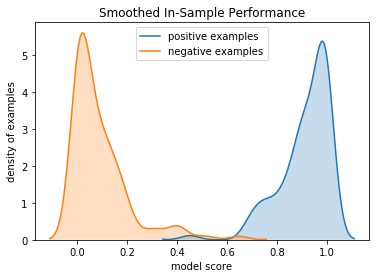

In [9]:
wvpy.util.dual_density_plot(probs=preds[:,1], istrue=encoded_Y, title="Smoothed In-Sample Performance")

In [10]:
log_loss(y_true=encoded_Y, y_pred=preds[:,1])

0.10286182208572497

In [11]:
encoded_Y_shuffled = encoded_Y.copy()
numpy.random.shuffle(encoded_Y_shuffled)

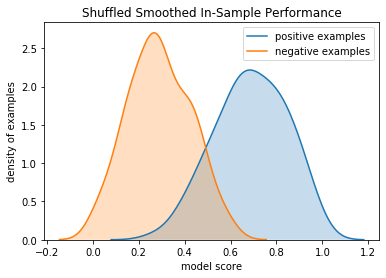

In [12]:
preds_shuffled = pipeline.fit_transform(X, encoded_Y_shuffled)
wvpy.util.dual_density_plot(
    probs=preds_shuffled[:,1], istrue=encoded_Y_shuffled, 
    title="Shuffled Smoothed In-Sample Performance")

In [13]:
log_loss(y_true=encoded_Y_shuffled, y_pred=preds_shuffled[:,1])

0.3793720680718812

In [14]:
def run_experiment(alpha):
    pipeline = mk_model(alpha)
    preds = pipeline.fit_transform(X, encoded_Y)
    loss = log_loss(y_true=encoded_Y, y_pred=preds[:,1])
    encoded_Y_shuffled = encoded_Y.copy()
    numpy.random.shuffle(encoded_Y_shuffled)
    preds_shuffled = pipeline.fit_transform(X, encoded_Y_shuffled)
    loss_shuffled = log_loss(y_true=encoded_Y_shuffled, y_pred=preds_shuffled[:,1])
    return pandas.DataFrame({
        'alpha': [alpha],
        'loss_on_signal': [loss],
        'loss_on_shuffled': [loss_shuffled],
        })

In [15]:
experiments = [0, 1.e-3, 1.e-2, 0.1, 1, 10] * 5
result_list = [run_experiment(alpha) for alpha in experiments]

In [16]:
res = pandas.concat(result_list)
res

,alpha,loss_on_signal,loss_on_shuffled
0,0.000,0.072545,0.400285
0,0.001,0.088090,0.319165
0,0.010,0.109101,0.346776
0,0.100,0.186068,0.456471
0,1.000,0.302453,0.545257
0,10.000,0.359678,0.589764
0,0.000,0.070526,0.374033
0,0.001,0.070599,0.364214
0,0.010,0.091001,0.346734
0,0.100,0.200852,0.494741


In [18]:
res.reset_index(inplace=True, drop=True)

In [19]:
res.to_csv('signal_measurements.csv', index=False)